In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import cv2
import numpy as np
import os
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm
from glob import glob
from pathlib import Path

In [2]:


# Load pretrained landmark model (68 points, 2D)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
import face_alignment
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, device=device, flip_input=False)


In [4]:
def create_nose_mask(image_path, save_path, log):
    try:
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        preds = fa.get_landmarks(img_rgb)
        if preds is None:
            return False
            
    except Warning as w:  # Catch warnings as exceptions
        return False

    landmarks = preds[0]
    nose_points = landmarks[27:36]  # indexes 27–35 in 0-based Python index

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(nose_points), 255)

    cv2.imwrite(save_path, mask)
    return True

In [5]:
import os
import warnings
import logging

def batch_create_nose_masks(src_dir, dst_dir, create_func, exts=('.jpg','.jpeg','.png')):
    """
    Generate nose masks for all images in src_dir and save in dst_dir.
    Skips files if the mask already exists.
    """
    os.makedirs(dst_dir, exist_ok=True)
    warnings.filterwarnings("error", message="No faces were detected.")

    for file in os.listdir(src_dir):
        if file.lower().endswith(exts):
            in_path  = os.path.join(src_dir, file)
            out_path = os.path.join(dst_dir, file)
            if not os.path.exists(out_path):
                try:
                    create_func(in_path, out_path, logging)
                except Warning as w:
                    logging.warning(f"Skipped {file}: {w}")
                except Exception as e:
                    logging.error(f"Error with {file}: {e}")

# ---- Apply to all splits (input only) ----
base_dir = "/workspace/data_splits"
splits = ["train", "val", "test"]

for split in splits:
    input_folder = os.path.join(base_dir, split, "input")
    mask_folder  = os.path.join(base_dir, split, "mask_input")
    batch_create_nose_masks(input_folder, mask_folder, create_nose_mask)

In [6]:
def img_to_patches(x, patch_size):
    # x: (B, C, H, W)
    B, C, H, W = x.shape
    assert H % patch_size == 0 and W % patch_size == 0
    ph, pw = patch_size, patch_size
    nh, nw = H // ph, W // pw
    x = x.reshape(B, C, nh, ph, nw, pw)
    x = x.permute(0,2,4,3,5,1).reshape(B, nh*nw, ph*pw*C)  # (B, N, patch_dim)
    return x, (nh, nw)

In [7]:
def patches_to_img(patches, patch_size, nh_nw, C):
    # patches: (B, N, patch_dim)
    B, N, D = patches.shape
    nh, nw = nh_nw
    ph = pw = patch_size
    x = patches.reshape(B, nh, nw, ph, pw, C).permute(0,5,1,3,2,4).reshape(B, C, nh*ph, nw*pw)
    return x

In [8]:
def mask_to_patch_mask(mask, patch_size):
    # mask: (B,1,H,W) binary [0,1]
    B, _, H, W = mask.shape
    ph = pw = patch_size
    nh, nw = H//ph, W//pw
    mask = mask.reshape(B, 1, nh, ph, nw, pw)
    mask = mask.mean(dim=(3,5))  # (B,1,nh,nw)
    patch_mask = (mask.view(B, nh*nw) > 0.1).float()  # (B, N)
    return patch_mask  # 1 where patch contains nos

In [9]:
from pathlib import Path

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def _map_stem_to_name(dir_path: Path):
    """Return {stem: filename} for allowed image files (first match per stem)."""
    m = {}
    for p in dir_path.iterdir():
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            m.setdefault(p.stem, p.name)  # keep first occurrence
    return m

def validate_files(img_dir, mask_dir, target_dir, verbose=True):
    img_dir, mask_dir, target_dir = map(Path, (img_dir, mask_dir, target_dir))

    img_map    = _map_stem_to_name(img_dir)
    mask_map   = _map_stem_to_name(mask_dir)
    target_map = _map_stem_to_name(target_dir)

    img_stems    = set(img_map.keys())
    mask_stems   = set(mask_map.keys())
    target_stems = set(target_map.keys())

    common = sorted(img_stems & mask_stems & target_stems)

    missing_mask   = sorted(img_stems - mask_stems)
    missing_target = sorted(img_stems - target_stems)
    orphan_masks   = sorted(mask_stems - img_stems)
    orphan_targets = sorted(target_stems - img_stems)

    if verbose:
        print(f"[validate] counts: img={len(img_stems)} mask={len(mask_stems)} target={len(target_stems)}")
        print(f"[validate] common triples: {len(common)}")
        if missing_mask:   print(f"[validate] missing masks for {len(missing_mask)} imgs, e.g. {missing_mask[:5]}")
        if missing_target: print(f"[validate] missing targets for {len(missing_target)} imgs, e.g. {missing_target[:5]}")
        if orphan_masks:   print(f"[validate] masks without imgs: {len(orphan_masks)}, e.g. {orphan_masks[:5]}")
        if orphan_targets: print(f"[validate] targets without imgs: {len(orphan_targets)}, e.g. {orphan_targets[:5]}")

    # Build (img_filename, target_filename) using the exact filenames found
    pairs = [(img_map[s], target_map[s]) for s in common]

    if len(pairs) == 0:
        raise ValueError(
            "No valid (img, mask, target) triples found.\n"
            f"Checked:\n  img_dir={img_dir}\n  mask_dir={mask_dir}\n  target_dir={target_dir}\n"
            "See [validate] logs above for mismatches."
        )
    return pairs

In [10]:
import math, torch.nn.functional as F
from torch.utils.data import DataLoader

import math, torch
import torch.nn.functional as F

def collate_keep_aspect_capped(batch, patch_size=16, multiple=16, max_tokens=4096):
    """
    Keep aspect; if tokens would exceed max_tokens, downscale uniformly to cap tokens.
    Then pad to batch max dims (multiples of `multiple`).
    """
    imgs, tgts, masks, orig_hw, files = [], [], [], [], []

    for b in batch:
        x = b["input"]    # [3,H,W]  float in [0,1]
        y = b["target"]   # [3,H,W]
        m = b["mask"]     # [1,H,W]
        H, W = x.shape[1], x.shape[2]

        # tokens with current size
        n_h = math.ceil(H / patch_size)
        n_w = math.ceil(W / patch_size)
        tokens = n_h * n_w

        if tokens > max_tokens:
            # scale so n_h*n_w <= max_tokens
            scale = math.sqrt(max_tokens / tokens)
            newH = max(patch_size, int(H * scale))
            newW = max(patch_size, int(W * scale))
            # round to multiple so patch grid divides nicely
            newH = (newH + multiple - 1) // multiple * multiple
            newW = (newW + multiple - 1) // multiple * multiple

            x = F.interpolate(x.unsqueeze(0), size=(newH, newW), mode="bilinear", align_corners=False).squeeze(0)
            y = F.interpolate(y.unsqueeze(0), size=(newH, newW), mode="bilinear", align_corners=False).squeeze(0)
            m = F.interpolate(m.unsqueeze(0), size=(newH, newW), mode="nearest").squeeze(0)  # keep binary
            H, W = newH, newW

        imgs.append(x); tgts.append(y); masks.append(m)
        orig_hw.append(torch.tensor([b.get("orig_h", H), b.get("orig_w", W)], dtype=torch.int32))
        files.append((b.get("input_file",""), b.get("mask_file",""), b.get("target_file","")))

    # pad to batch max
    Ht = max(t.shape[1] for t in imgs)
    Wt = max(t.shape[2] for t in imgs)
    # round up to multiple
    Ht = (Ht + multiple - 1) // multiple * multiple
    Wt = (Wt + multiple - 1) // multiple * multiple

    def pad_to(t, Ht, Wt): return F.pad(t, (0, Wt - t.shape[2], 0, Ht - t.shape[1]))

    X = torch.stack([pad_to(t, Ht, Wt) for t in imgs])
    Y = torch.stack([pad_to(t, Ht, Wt) for t in tgts])
    M = torch.stack([pad_to(t, Ht, Wt) for t in masks])
    OHW = torch.stack(orig_hw)

    return {"input": X, "target": Y, "mask": M, "orig_hw": OHW, "files": files}

In [11]:
from pathlib import Path
from torch.utils.data import Dataset
import torch, cv2
import numpy as np

class NoseFolderDataset(Dataset):
    def __init__(self, img_dir, mask_dir, target_dir, size=256):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.target_dir = Path(target_dir)
        self.file_pairs = validate_files(self.img_dir, self.mask_dir, self.target_dir)   # [(img_name, tgt_name), ...]

    def __len__(self):
        return len(self.file_pairs)

    def _read_rgb(self, path):
        img = cv2.imread(str(path), cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        # (H,W,3) uint8
        return img

    def _read_mask(self, path):
        
        m = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if m is None:
            raise FileNotFoundError(path)
        m = (m > 127).astype(np.uint8)                    # (H,W) 0/1
        return m

    def __getitem__(self, idx):
        fname, target_f = self.file_pairs[idx]
        ip, mp, tp = self.img_dir/fname, self.mask_dir/fname, self.target_dir/target_f

        img    = self._read_rgb(ip)     # H,W,3
        target = self._read_rgb(tp)     # H,W,3
        mask   = self._read_mask(mp)    # H,W

        if img.shape[:2] != target.shape[:2]:
            # minimal: resize target to img (or vice-versa, pick one consistently)
            target = cv2.resize(target, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_AREA)
        if img.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        H, W = img.shape[:2]
        img_t  = torch.from_numpy(img).permute(2,0,1).float()/255.0
        tgt_t  = torch.from_numpy(target).permute(2,0,1).float()/255.0
        mask_t = torch.from_numpy(mask).unsqueeze(0).float()

        return {
            "input": img_t, "target": tgt_t, "mask": mask_t,
            "orig_h": H, "orig_w": W,
            "input_file": str(ip), "mask_file": str(mp), "target_file": str(tp),
        }

In [14]:
IMG_DIR    = "/workspace/data_splits/train/input"
MASK_DIR   = "/workspace/data_splits/train/mask_input"
TARGET_DIR = "/workspace/data_splits/train/target"

ds = NoseFolderDataset(IMG_DIR, MASK_DIR, TARGET_DIR, size=256)
val_ds  = NoseFolderDataset("/workspace/data_splits/val/input",
                            "/workspace/data_splits/val/mask_input",
                            "/workspace/data_splits/val/target",
                            size=256)

test_ds = NoseFolderDataset("/workspace/data_splits/test/input",
                            "/workspace/data_splits/test/mask_input",
                            "/workspace/data_splits/test/target",
                            size=256)
# check first sample
sample = ds[0]
print(sample["input"].shape, sample["target"].shape, sample["mask"].min().item(), sample["mask"].max().item())


[validate] counts: img=536 mask=513 target=536
[validate] common triples: 513
[validate] missing masks for 23 imgs, e.g. ['WhatsApp Image 2025-07-12 at 1.09.33 AM (1)', 'WhatsApp Image 2025-07-12 at 1.09.35 AM', 'WhatsApp Image 2025-07-12 at 1.30.13 AM (6)', 'WhatsApp Image 2025-07-12 at 1.33.47 AM (4)', 'WhatsApp Image 2025-07-12 at 1.38.10 AM']
[validate] counts: img=67 mask=63 target=67
[validate] common triples: 63
[validate] missing masks for 4 imgs, e.g. ['WhatsApp Image 2025-07-12 at 5.46.30 PM', 'WhatsApp Image 2025-07-12 at 5.46.31 PM (2)', 'WhatsApp Image 2025-07-12 at 5.53.17 PM (1)', 'WhatsApp Image 2025-07-12 at 6.20.03 PM']
[validate] counts: img=68 mask=65 target=68
[validate] common triples: 65
[validate] missing masks for 3 imgs, e.g. ['WhatsApp Image 2025-07-12 at 1.36.12 AM (2)', 'WhatsApp Image 2025-07-12 at 5.38.14 PM (1)', 'WhatsApp Image 2025-07-12 at 5.53.22 PM (1)']
torch.Size([3, 1600, 600]) torch.Size([3, 1600, 600]) 0.0 1.0


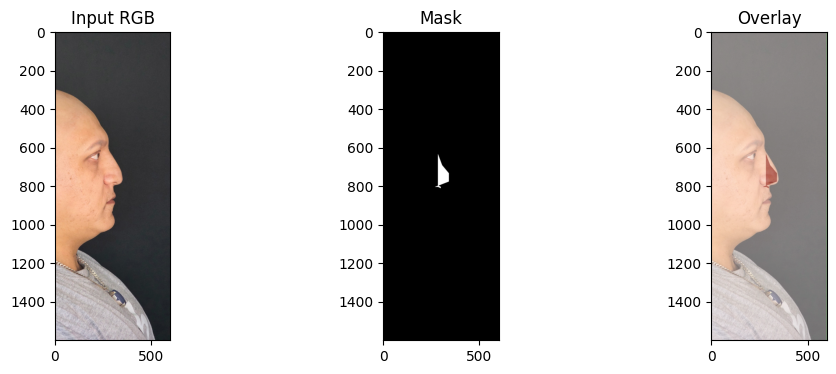

In [15]:
import matplotlib.pyplot as plt

sample = ds[0]
inp   = sample["input"][:3]   # take only RGB
mask  = sample["mask"][0]     # (H,W)
tgt   = sample["target"]

inp_np  = inp.permute(1,2,0).numpy()
tgt_np  = tgt.permute(1,2,0).numpy()
mask_np = mask.numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(inp_np); plt.title("Input RGB")
plt.subplot(1,3,2); plt.imshow(mask_np, cmap="gray"); plt.title("Mask")
plt.subplot(1,3,3); plt.imshow(inp_np); plt.imshow(mask_np, cmap="Reds", alpha=0.4); plt.title("Overlay")
plt.show()

In [16]:
# --------------------------- Transformer blocks ------------------------------

class MLP(nn.Module):
    def __init__(self, dim, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        hidden = int(dim*mlp_ratio)
        self.fc1 = nn.Linear(dim, hidden)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden, dim)
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        x = self.fc1(x); x = self.act(x); x = self.drop(x)
        x = self.fc2(x); x = self.drop(x)
        return x

class MHA_with_bias(nn.Module):
    def __init__(self, embed_dim, num_heads, attn_dropout=0.0):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=attn_dropout, batch_first=True)
    def forward(self, x, attn_bias=None):
        # x: (B,N,D); attn_bias: (B,N,N) floats added to logits
        B, N, D = x.shape
        if attn_bias is None:
            out, _ = self.mha(x, x, x, need_weights=False)
            return out
        outs = []
        for b in range(B):
            mask_b = attn_bias[b]  # (N,N)
            out_b, _ = self.mha(x[b:b+1], x[b:b+1], x[b:b+1], attn_mask=mask_b)
            outs.append(out_b)
        return torch.cat(outs, dim=0)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = MHA_with_bias(dim, heads, attn_dropout=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = MLP(dim, mlp_ratio, drop)
    def forward(self, x, attn_bias=None):
        x = x + self.attn(self.norm1(x), attn_bias=attn_bias)
        x = x + self.mlp(self.norm2(x))
        return x

class PatchEmbed(nn.Module):
    def __init__(self, in_ch, embed_dim, patch_size):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Linear((patch_size*patch_size*in_ch), embed_dim)
    def forward(self, x):
        patches, (nh, nw) = img_to_patches(x, self.patch_size)  # (B, N, patch_dim)
        x = self.proj(patches)  # (B, N, embed_dim)
        return x, (nh, nw)


In [17]:
# --------------------------- Generator (Transformer + Conv decoder) ----------

class ConvDecoder(nn.Module):
    def __init__(self, in_dim, out_ch=3, up_factor=8, res_max=0.75):
        super().__init__()
        self.res_max = res_max
        self.body = nn.Sequential(
            nn.Conv2d(in_dim, 256, 3, padding=1), nn.GELU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, 3, padding=1),   nn.GELU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, 3, padding=1),    nn.GELU(),
            nn.Upsample(scale_factor=max(1, up_factor//4), mode='bilinear', align_corners=False),
            nn.Conv2d(64, out_ch, 3, padding=1)
        )
        nn.init.zeros_(self.body[-1].weight)
        nn.init.zeros_(self.body[-1].bias)

        self._alpha = nn.Parameter(torch.tensor(0.0))  # sigmoid(_alpha) ~ 0.5 initially → ~0.375 residual cap

    def forward(self, feat):
        raw = self.body(feat)                 # (B,3,H,W)
        scale = torch.sigmoid(self._alpha) * self.res_max
        delta = torch.tanh(raw) * scale
        return delta
        
def feather_mask(mask, k=9):
    return F.avg_pool2d(mask, kernel_size=k, stride=1, padding=k//2).clamp(0,1)


class NoseTransformer(nn.Module):
    def __init__(self, in_ch=4, out_ch=3, embed_dim=512, patch_size=8, depth=6, num_heads=8,
                 bias_pos=+1.0, bias_neg=-0.5):
        super().__init__()
        self.patch_size  = patch_size
        self.embed_dim   = embed_dim
        self.out_ch      = out_ch
        self.bias_pos    = bias_pos
        self.bias_neg    = bias_neg

        self.patch_embed = PatchEmbed(in_ch, embed_dim, patch_size)
        self.pos_embed   = None
        self.blocks      = nn.ModuleList([TransformerBlock(embed_dim, num_heads) for _ in range(depth)])
        self.decoder     = ConvDecoder(in_dim=embed_dim, out_ch=out_ch, up_factor=patch_size)

    def _build_attn_bias(self, patch_mask):
        pm = patch_mask.float()                   # (B,N)
        same = torch.einsum('bi,bj->bij', pm, pm) # nose↔nose
        q_is_nose = pm.unsqueeze(2)               # (B,N,1)
        k_not_nose = (1.0 - pm).unsqueeze(1)      # (B,1,N)
        nose_to_non = q_is_nose * k_not_nose      # (B,N,N)
        attn_bias = self.bias_pos * same + self.bias_neg * nose_to_non
        return attn_bias

    def forward(self, inp, patch_mask=None):
        """
        inp: (B, 4, H, W)  [RGB + mask]
        """
        B, _, H, W = inp.shape
        x, (nh, nw) = self.patch_embed(inp)        # (B, N, D)
        N = x.shape[1]

        if self.pos_embed is None or self.pos_embed.shape[1] != N:
            self.pos_embed = nn.Parameter(torch.zeros(1, N, self.embed_dim, device=x.device))
            nn.init.trunc_normal_(self.pos_embed, std=0.02)
        x = x + self.pos_embed

        attn_bias = self._build_attn_bias(patch_mask) if patch_mask is not None else None
        for blk in self.blocks:
            x = blk(x, attn_bias=attn_bias)

        feat  = x.transpose(1, 2).reshape(B, self.embed_dim, nh, nw)  # (B, D, nh, nw)
        delta = self.decoder(feat)                                    # (B, 3, H, W)

        rgb = inp[:, :3]
        mask1 = inp[:, 3:4]
        hard   = dilate_mask_binary(mask1, k=11, iters=2)
        m_soft = feather_mask(hard, k=9)
        m3     = m_soft.repeat(1, 3, 1, 1)
        out = (rgb + delta * m3)
        return out

# --------------------------- PatchGAN Discriminator --------------------------
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=3, base_channels=64):
        super().__init__()
        # Input: (B, in_ch, H, W)
        # Output: (B, 1, H/16, W/16) patch realism map
        layers = []
        ch = base_channels
        layers += [nn.Conv2d(in_ch, ch, 4, stride=2, padding=1), nn.LeakyReLU(0.2, inplace=True)]

        layers += [nn.Conv2d(ch, ch*2, 4, stride=2, padding=1), nn.BatchNorm2d(ch*2), nn.LeakyReLU(0.2, inplace=True)]
        ch *= 2
        layers += [nn.Conv2d(ch, ch*2, 4, stride=2, padding=1), nn.BatchNorm2d(ch*2), nn.LeakyReLU(0.2, inplace=True)]
        ch *= 2
        layers += [nn.Conv2d(ch, ch*2, 4, stride=2, padding=1), nn.BatchNorm2d(ch*2), nn.LeakyReLU(0.2, inplace=True)]

        # final conv to 1-channel patch map
        layers += [nn.Conv2d(ch*2, 1, 4, padding=1)]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class VGGPerceptualLoss(nn.Module):
    """
    VGG16 feature L1 loss. Works on inputs in [0,1].
    If mask is given (B,1,H,W), it is downsampled per VGG stage and used
    to weight the feature differences spatially.
    """
    def __init__(self, layers=(3, 8, 15, 22), layer_weights=None):
        super().__init__()
        # relu1_2=3, relu2_2=8, relu3_3=15, relu4_3=22 in torchvision VGG16.features
        self.layers = tuple(layers)
        self.layer_weights = (
            [1.0] * len(self.layers) if layer_weights is None else layer_weights
        )

        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features
        self.vgg = vgg.eval()
        for p in self.vgg.parameters():
            p.requires_grad_(False)

        # register mean/std buffers for ImageNet normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)
        self.register_buffer('mean', mean, persistent=False)
        self.register_buffer('std',  std,  persistent=False)

    def _norm(self, x):
        # x expected in [0,1]
        return (x - self.mean) / self.std

    def forward(self, pred, target, mask=None):
        """
        pred, target: (B,3,H,W) in [0,1]
        mask (optional): (B,1,H,W) with 0..1 weights (e.g., your nose mask)
        """
        x = self._norm(pred)
        y = self._norm(target)

        loss = 0.0
        idx_set = set(self.layers)
        lw_iter = iter(self.layer_weights)

        # run through the VGG and collect selected layers
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            y = layer(y)

            if i in idx_set:
                w = next(lw_iter)
                if mask is None:
                    # plain feature L1
                    loss += w * F.l1_loss(x, y)
                else:
                    # masked feature L1 (downsample mask to feature size)
                    m = F.interpolate(mask, size=x.shape[-2:], mode='bilinear', align_corners=False)
                    num = (m * (x - y).abs()).sum()
                    den = m.sum() + 1e-6
                    loss += w * (num / den)

        return loss

In [19]:
def dilate_mask_binary(mask, k=11, iters=2):
    """Binary dilation. mask: (B,1,H,W) in {0,1} float."""
    out = mask
    for _ in range(iters):
        out = F.max_pool2d(out, kernel_size=k, stride=1, padding=k//2)
    return out.clamp(0,1)

def erode_mask_binary(mask, k=11, iters=1):
    """Binary erosion via max-pool trick."""
    x = 1.0 - mask
    for _ in range(iters):
        x = F.max_pool2d(x, kernel_size=k, stride=1, padding=k//2)
    return (1.0 - x).clamp(0,1)

def feather_mask(mask, k=9):
    """Soft edge (0..1) via avg-pool (feathered band)."""
    return F.avg_pool2d(mask, kernel_size=k, stride=1, padding=k//2).clamp(0,1)

# ---------- patch mask helper ----------
def mask_to_patch_mask(mask, patch_size):
    """
    Convert (B,1,H,W) 0/1 (or soft) mask to (B, N) patch weights by
    averaging within non-overlapping p×p patches.
    """
    B, _, H, W = mask.shape
    p = patch_size
    # trim if H/W not divisible by p
    Ht, Wt = (H // p) * p, (W // p) * p
    m = mask[:, :, :Ht, :Wt]
    # (B,1, H/p, p, W/p, p) -> mean over the two 'p' dims -> (B,1,H/p,W/p)
    m = m.view(B, 1, Ht//p, p, Wt//p, p).mean(dim=(3,5))
    return m.flatten(1)  # (B, N)

# ---------- simple PatchGAN (1-channel real/fake map) ----------
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=6, base=64):
        super().__init__()
        c = base
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,   c, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c,     c*2, 4, 2, 1), nn.BatchNorm2d(c*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c*2,   c*4, 4, 2, 1), nn.BatchNorm2d(c*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c*4,   c*8, 4, 2, 1), nn.BatchNorm2d(c*8), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c*8,     1, 4, 1, 1)
        )
    def forward(self, x): return self.net(x)

        

# ---------- validation (masked L1 using the same soft mask) ----------
@torch.no_grad()
def validate_epoch(G, loader, device, patch_size):
    G.eval()
    tot, n = 0.0, 0
    for batch in loader:
        rgb    = batch["input"].to(device)   # (B,4,H,W)  [RGB+mask]
        target = batch["target"].to(device)  # (B,3,H,W)
        mask   = batch["mask"].to(device)    # (B,1,H,W)
        inp = torch.cat([rgb, mask], dim=1)
        # same expansion/feathering as train
        hard   = dilate_mask_binary(mask, k=11, iters=2)
        m_soft = feather_mask(hard, k=9)

        # patch-level attention from expanded binary mask
        pm = mask_to_patch_mask(hard, patch_size)

        pred = G(inp, patch_mask=pm)

        l1m = ((pred - target).abs() * m_soft).sum() / (m_soft.sum() + 1e-6)
        b = inp.size(0)
        tot += l1m.item() * b
        n   += b
    return tot / max(1,n)

# ---------- training ----------
def train_gan(
    train_loader,
    val_loader,
    *,
    patch_size=8,
    epochs=20,
    out_dir="ckpts_gan",
    lr_G=2e-4,
    lr_D=1e-4,
    adv_start_w=0.05,          # starting adv weight (ramps to 0.05 by ep 5)
    lambda_l1=5.0,             # masked L1 (soft mask)
    lambda_out_id=0.5,         # identity outside edit band
    use_perc=False,
    perceptual_fn=None,
    amp=True,
    device="cuda"
):
    os.makedirs(out_dir, exist_ok=True)

    # ----- build models -----
    G = NoseTransformer(in_ch=4, out_ch=3, embed_dim=512,
                        patch_size=patch_size, depth=6, num_heads=8).to(device)
    D = PatchDiscriminator(in_ch=6, base=64).to(device)

    # ----- opt + sched -----
    opt_G = torch.optim.AdamW(G.parameters(), lr=lr_G, betas=(0.5, 0.999))
    opt_D = torch.optim.AdamW(D.parameters(), lr=lr_D, betas=(0.5, 0.999))
    sch_G = torch.optim.lr_scheduler.CosineAnnealingLR(opt_G, T_max=epochs, eta_min=lr_G*0.1)
    sch_D = torch.optim.lr_scheduler.CosineAnnealingLR(opt_D, T_max=epochs, eta_min=lr_D*0.1)

    scaler_G = torch.amp.GradScaler('cuda', enabled=amp)
    scaler_D = torch.amp.GradScaler('cuda', enabled=amp)

    best, best_path = float("inf"), None

    for ep in range(1, epochs+1):
        G.train(); D.train()
        pbar = tqdm(train_loader, desc=f"train {ep}/{epochs}")
        seen = 0
        # ramp adversarial weight up to adv_start_w by epoch 5
        adv_w = adv_start_w * min(1.0, ep/5.0)

        # -------- iterate minibatches --------
        for batch in pbar:
            rgb    = batch["input"].to(device)   # (B,4,H,W)  [RGB+mask]
            target = batch["target"].to(device)  # (B,3,H,W)
            mask   = batch["mask"].to(device)    # (B,1,H,W)
            
            inp = torch.cat([rgb, mask], dim=1)

            # expand + feather once per batch
            hard   = dilate_mask_binary(mask, k=11, iters=2)   # expanded binary region
            m_soft = feather_mask(hard, k=9)                   # soft weights 0..1
            outside = 1.0 - erode_mask_binary(hard, k=11, iters=2)

            # patch attention mask from expanded binary
            pm = mask_to_patch_mask(hard, patch_size)

            # -------- D step --------
            opt_D.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=amp):
                with torch.no_grad():
                    fake = G(inp, patch_mask=pm)  # G already fuses with soft mask internally
                real_logits = D(torch.cat([rgb, target], dim=1))
                fake_logits = D(torch.cat([rgb, fake],   dim=1))
                # hinge loss
                d_loss = torch.relu(1. - real_logits).mean() + torch.relu(1. + fake_logits).mean()

            scaler_D.scale(d_loss).backward()
            scaler_D.step(opt_D)
            scaler_D.update()

            # -------- G step --------
            opt_G.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=amp):
                pred = G(inp, patch_mask=pm)

                # reconstruction terms (use the *soft* mask)
                l1_mask  = ((pred - target).abs() * m_soft).sum() / (m_soft.sum() + 1e-6)
                l_out_id = ((pred - rgb).abs()    * outside).sum() / (outside.sum() + 1e-6)

                # adversarial (generator wants D to say "real")
                fake_logits_g = D(torch.cat([rgb, pred], dim=1))
                adv_loss = -fake_logits_g.mean()

                # optional perceptual (also weight by m_soft if provided)
                if use_perc and (perceptual_fn is not None):
                    perc_loss = perceptual_fn(pred, target, mask=m_soft)
                else:
                    perc_loss = 0.0

                g_loss = (lambda_l1 * l1_mask
                          + lambda_out_id * l_out_id
                          + adv_w * adv_loss
                          + 0.2 * perc_loss)

            scaler_G.scale(g_loss).backward()
            scaler_G.step(opt_G)
            scaler_G.update()

            # progress
            b = inp.size(0); seen += b
            pbar.set_postfix({
                "D": f"{d_loss.item():.3f}",
                "G": f"{g_loss.item():.3f}",
                "L1m": f"{l1_mask.item():.4f}",
                "OID": f"{l_out_id.item():.4f}",
                "ADV": f"{adv_loss.item():.4f}",
                "lrG": f"{sch_G.get_last_lr()[0]:.2e}"
            })

        sch_G.step(); sch_D.step()

        # -------- validation --------
        val_l1m = validate_epoch(G, val_loader, device, patch_size)

        # -------- save --------
        ckpt = {
            "epoch": ep,
            "G": G.state_dict(),
            "D": D.state_dict(),
            "opt_G": opt_G.state_dict(),
            "opt_D": opt_D.state_dict(),
            "val_l1m": val_l1m,
            "cfg": {
                "patch_size": patch_size,
                "lambda_l1": lambda_l1,
                "lambda_out_id": lambda_out_id,
                "adv_start_w": adv_start_w
            }
        }
        last_path = os.path.join(out_dir, "last.pt")
        torch.save(ckpt, last_path)

        is_best = val_l1m < best
        if is_best:
            best = val_l1m
            best_path = os.path.join(out_dir, "best_l1_mask.pt")
            torch.save(ckpt, best_path)

        print(f"[epoch {ep}] val L1(mask)={val_l1m:.4f}  |  best={best:.4f}  saved:{is_best}")

    return best_path or last_path

In [20]:
print("autocast is:", getattr(globals(), "autocast", "<no alias>"))
print("torch.autocast:", torch.autocast)
print("GradScaler:", torch.amp.GradScaler)

autocast is: <no alias>
torch.autocast: <class 'torch.amp.autocast_mode.autocast'>
GradScaler: <class 'torch.amp.grad_scaler.GradScaler'>


In [21]:
import os, torch
import torchvision.transforms as T
from PIL import Image

@torch.no_grad()
def run_test_gan(
    ckpt_path,                 # e.g. "ckpts_gan/best_l1_mask.pt"
    test_loader,               # DataLoader yielding dicts with input/mask/target/... (your NoseFolderDataset)
    device=None,
    patch_size=8,
    save_dir="results_gan",
    panel_size=256
):
    """
    Loads G from checkpoint and saves panels: input | target | prediction.

    Expects each batch item to have:
      - "input":  (B,4,H,W)  [RGB + mask]
      - "mask":   (B,1,H,W)
      - "target": (B,3,H,W)
      - "input_file", "target_file": lists of file paths (for naming)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(save_dir, exist_ok=True)

    # --- rebuild Generator with same hyperparams as training ---
    # (adjust embed_dim/depth/heads if you changed them in training)
    G = NoseTransformer(in_ch=4, out_ch=3, embed_dim=512, patch_size=patch_size, depth=6, num_heads=8).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    state_dict = ckpt["G"] if isinstance(ckpt, dict) and "G" in ckpt else ckpt
    G.load_state_dict(state_dict, strict=False)
    G.eval()

    to_pil = T.ToPILImage()
    resize = T.Resize((panel_size, panel_size), interpolation=T.InterpolationMode.BILINEAR, antialias=True)

    for batch in test_loader:
        x      = batch["input"].to(device)    # (B,4,H,W)
        mask   = batch["mask"].to(device)     # (B,1,H,W)
        target = batch["target"].to(device)   # (B,3,H,W)
        pmask  = mask_to_patch_mask(mask, patch_size)  # (B,N)

        pred = G(x, patch_mask=pmask).clamp(0,1)

        input_files  = batch.get("input_file",  None)
        target_files = batch.get("target_file", None)

        B = pred.size(0)
        for b in range(B):
            inp_rgb = x[b, :3].detach().cpu()
            tgt_rgb = target[b].detach().cpu()
            prd_rgb = pred[b].detach().cpu()

            # uniform panel size
            inp_rgb = resize(inp_rgb)
            tgt_rgb = resize(tgt_rgb)
            prd_rgb = resize(prd_rgb)

            inp_pil = to_pil(inp_rgb)
            tgt_pil = to_pil(tgt_rgb)
            prd_pil = to_pil(prd_rgb)

            w, h = inp_pil.size
            panel = Image.new("RGB", (w*3, h))
            panel.paste(inp_pil, (0,   0))
            panel.paste(tgt_pil, (w,   0))
            panel.paste(prd_pil, (2*w, 0))

            # filename
            if input_files is not None and target_files is not None:
                in_fn  = os.path.basename(input_files[b])
                tgt_fn = os.path.basename(target_files[b])
                save_name = f"{os.path.splitext(in_fn)[0]}__{os.path.splitext(tgt_fn)[0]}.png"
            else:
                save_name = f"sample_{b}.png"

            # sanitize a bit
            save_name = save_name.replace(" ", "_").replace("(", "").replace(")", "")
            panel.save(os.path.join(save_dir, save_name))

    print(f"Saved test panels to: {save_dir}")

In [25]:
train_ds = NoseFolderDataset("/workspace/data_splits/train/input",
                                     "/workspace/data_splits/train/mask_input",
                                     "/workspace/data_splits/train/target")
val_ds   = NoseFolderDataset("/workspace/data_splits/val/input",
                                     "/workspace/data_splits/val/mask_input",
                                     "/workspace/data_splits/val/target")

val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2,
                          pin_memory=True, collate_fn=lambda b: collate_keep_aspect(b, multiple=64),persistent_workers=False )

PATCH = 32            # or 32
MULT  = PATCH
MAXTOK = 4096         # ≈ 64×64 tokens

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=True,
                          persistent_workers=False,
                          collate_fn=lambda b: collate_keep_aspect_capped(b, patch_size=PATCH, multiple=MULT, max_tokens=MAXTOK))

val_loader = DataLoader(val_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=True,
                          persistent_workers=False,
                          collate_fn=lambda b: collate_keep_aspect_capped(b, patch_size=PATCH, multiple=MULT, max_tokens=MAXTOK))

[validate] counts: img=536 mask=513 target=536
[validate] common triples: 513
[validate] missing masks for 23 imgs, e.g. ['WhatsApp Image 2025-07-12 at 1.09.33 AM (1)', 'WhatsApp Image 2025-07-12 at 1.09.35 AM', 'WhatsApp Image 2025-07-12 at 1.30.13 AM (6)', 'WhatsApp Image 2025-07-12 at 1.33.47 AM (4)', 'WhatsApp Image 2025-07-12 at 1.38.10 AM']
[validate] counts: img=67 mask=63 target=67
[validate] common triples: 63
[validate] missing masks for 4 imgs, e.g. ['WhatsApp Image 2025-07-12 at 5.46.30 PM', 'WhatsApp Image 2025-07-12 at 5.46.31 PM (2)', 'WhatsApp Image 2025-07-12 at 5.53.17 PM (1)', 'WhatsApp Image 2025-07-12 at 6.20.03 PM']


In [26]:
def print_cuda_mem(tag=""):
    import torch
    a = torch.cuda.memory_allocated() / 1e9
    r = torch.cuda.memory_reserved() / 1e9
    print(f"[{tag}] allocated={a:.2f} GB  reserved={r:.2f} GB")

print_cuda_mem("before")
# after building G/D
print_cuda_mem("after models")
# inside loop occasionally

[before] allocated=83.21 GB  reserved=83.79 GB
[after models] allocated=83.21 GB  reserved=83.79 GB


In [27]:
if __name__ == "__main__":
    TRAIN_IMG = "/workspace/data_splits/train/input"
    TRAIN_MSK = "/workspace/data_splits/mask_input"
    TRAIN_TGT = "/workspace/data_splits/train/target"

    VAL_IMG   = "/workspace/data_splits/val/input"
    VAL_MSK   = "/workspace/data_splits/val/mask_input"
    VAL_TGT   = "/workspace/data_splits/val/target"

    size = 256
    patch_size = 8
    bs = 8

    perceptual_fn = VGGPerceptualLoss(layers=(3,8,15,22)).to(device)
    
    best = train_gan(
    train_loader, val_loader,
    patch_size=patch_size,
    epochs=20,
    out_dir="ckpts_gan_v4",
    use_perc=True,                 # since you're passing perceptual_fn
    perceptual_fn=perceptual_fn,
    amp=True
)
   

train 1/20:   0%|          | 0/257 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 882.00 MiB. GPU 0 has a total capacity of 79.25 GiB of which 708.75 MiB is free. Process 398051 has 78.55 GiB memory in use. Of the allocated memory 77.82 GiB is allocated by PyTorch, and 227.20 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
patch_size = 8

test_img_dir    = "/workspace/processed/val/A"
test_mask_dir   = "/workspace/test_nose_mask"
test_target_dir = "/workspace/processed/val/B"

test_ds = NoseFolderDataset(test_img_dir, test_mask_dir, test_target_dir, size=256)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

# Run
run_test_gan(
    ckpt_path="ckpts_gan_v3/best_l1_mask.pt",
    test_loader=test_loader,
    device=device,
    patch_size=patch_size,
    save_dir="/workspace/results_gan_v3",
    panel_size=256
)

Saved test panels to: /workspace/results_gan_v3
